In [1]:
from pathlib import Path
from pyexplain.benchmark.file_utils import *
from pyexplain.benchmark.plot import *
import IPython
import numpy as np
from collections import defaultdict
from datetime import datetime

pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight']= 'bold'

In [2]:
# MAC
environment = 'MAC'
BASE_MAC_LINUX = {
    'MAC': '/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/',
    'LINUX': '/home/emilio/research/'
}

PATH_FIGURES_POST_PAPER = Path(BASE_MAC_LINUX[environment] + "01_holygrail/latex/journal/jair21/figures/")
EXPERIMENT_RESULTS = Path(BASE_MAC_LINUX[environment] + "06_HPC_Experiments/experiments/data/output/")
BASE_OUTPUT_PATH = BASE_MAC_LINUX[environment] + "/06_HPC_Experiments/experiments/data/output/"
REMOTE_EXPERIMENT_RESULTS = "/data/brussel/101/vsc10143/hpc_experiments2/experiments/data/output/"

In [9]:
def heatmap_costs(mus_cost, ocus_cost,jmp=60, fig_path=None):
    min_val, max_val = 60, max(ocus_cost+mus_cost)
    print("min_explanation_cost=", min_val)
    print("max_explanation_cost=", max_val)
    all_vals = list(range(min_val, max_val, jmp))
    matx = [[0 for i in all_vals] for j in all_vals]

    coordinate_yi = lambda yi: len(all_vals) - 1 - yi 
    coordinate_xi = lambda xi: xi

    d_costs = defaultdict(int)
    for m_cost, o_cost in zip(mus_cost, ocus_cost):
        d_costs[(m_cost, o_cost)] += 1
        #if m_cost < o_cost:            print("possible ????", m_cost, o_cost)
        
    for ((m_cost, o_cost), val) in d_costs.items():
        
        xi, yi = ((o_cost-min_val)//jmp),  ((m_cost-min_val)//jmp)
        if m_cost < 60 or o_cost < 60:
            x_zero_cost = 0 if o_cost < 60 else xi
            y_zero_cost = 0 if m_cost < 60 else yi
            matx[coordinate_yi(0)][coordinate_xi(0)] += val
        else:
            matx[coordinate_yi(yi)][coordinate_xi(xi)] += val

    for i in range(len(all_vals)):
        for j in range(len(all_vals)):
            matx[i][j] = 0 if (matx[i][j] == 0) else np.log(matx[i][j])

    fig, ax = plt.subplots(figsize=(5,5))

    matx2 = [[0 for i in all_vals] for j in all_vals]

    im = ax.imshow(matx, cmap='binary', interpolation='nearest')

    rng = np.arange(len(all_vals))
    rng_rev = list(reversed(np.arange(len(all_vals))))

    ax.set_xticks(rng)
    ax.set_yticks(rng_rev)

    # ... and label them with the respective list entries.
    xticksLabels = [str(val) if idx % 2 == 0 else "" for idx, val in  enumerate(all_vals) ]
    ax.set_xticklabels(xticksLabels,fontsize=16)
    ax.xaxis.label.set_size(20)
    ax.set_ylabel("MUS cost")
    
    ax.yaxis.label.set_size(20)
    ax.set_xlabel("OCUS cost")
    
    yticksLabels = xticksLabels
    ax.set_yticklabels(yticksLabels,fontsize=16)
    
    ax.plot(rng,rng_rev,linestyle='--')

    if fig_path:
        fig.savefig(fname=fig_path, bbox_inches ="tight",
            transparent = True,)



check which instances do not timeout for mus and for 

In [10]:
#  Optux Previsou results = 2021061714
msg_output_folders = [
    "EXPLANATION_QUALITY_2/2022032111/"
]

path_msg_output_dirs = [BASE_OUTPUT_PATH + o for o in msg_output_folders]
df = folder_to_pandas_df_pickle(path_msg_output_dirs)

ignored_instances = []
ignored_instances += ["frietkot", "simple"]
ignored_instances += list(set(i for i in df["params_instance"] if 'sudoku-4x4' in i))

def extract_explanation_cost(explanation_sequence):
    return [expl["cost"] for expl in explanation_sequence]

df["explanation_cost"] = df.apply(
    lambda row: extract_explanation_cost(row["explanation"]), axis=1)
df["explanation_len"] = df.apply(
    lambda row: len(row["explanation"]), axis=1)

df_msg = df[
    ~df["params_instance"].isin(ignored_instances)
]

selected_columns = ["params_explanation_computer", "params_instance","explanation_cost", 'explanation_len']

In [11]:
df_sub_cols = df[["params_explanation_computer", "params_instance","explanation_cost", "time_timedout"]]
assert len(df_sub_cols[df_sub_cols["time_timedout"]]) == 0, "Timedout instances"

### checking if the explanation sequences are correct and similar!

min_explanation_cost= 60
max_explanation_cost= 1570
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/heatmapcosts_ocus_mus_2022070718.pdf


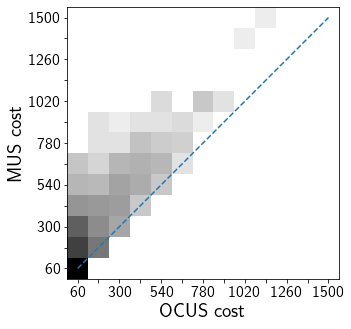

In [12]:
def check_explanation_sequence(mus_expl_seq, ocus_expl_seq):
    
    assert len(mus_expl_seq) == len(ocus_expl_seq), "Explanation sequence should be of same length"
    mus_costs, ocus_costs = [], []
    for mus_expl, ocus_expl in zip(mus_expl_seq, ocus_expl_seq):
        mus_costs.append(mus_expl["cost"])
        ocus_costs.append(ocus_expl["cost"])
        if mus_expl["cost"] < ocus_expl["cost"]:
            print("Is this possible?")
    return mus_costs, ocus_costs

df_msg_pivot = df_msg.pivot(
    index='params_instance', 
    columns='params_explanation_computer', 
    values='explanation').reset_index()

all_mus_costs, all_ocus_costs = [], []

for id, row in df_msg_pivot.iterrows():
    mus_costs, ocus_costs = check_explanation_sequence(mus_expl_seq=row["MUS"], ocus_expl_seq=row["OCUS"])
    all_mus_costs += mus_costs
    all_ocus_costs += ocus_costs
    
heatmap_costs(
    mus_cost=all_mus_costs,
    ocus_cost=all_ocus_costs,
    jmp=120,
    fig_path=PATH_FIGURES_POST_PAPER / ("heatmapcosts_ocus_mus_" + datetime.now().strftime("%Y%m%d%H") + ".pdf")
)
print(PATH_FIGURES_POST_PAPER / ("heatmapcosts_ocus_mus_" + datetime.now().strftime("%Y%m%d%H") + ".pdf"))


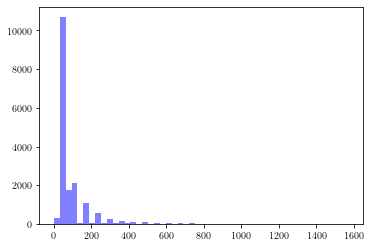

In [28]:
#!/usr/bin/env python

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
num_bins = 50
n, bins, patches = plt.hist(all_mus_costs, num_bins, facecolor='blue', alpha=0.5)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

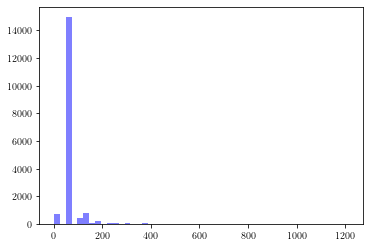

In [8]:
#!/usr/bin/env python

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
num_bins = 50
n, bins, patches = plt.hist(all_ocus_costs, num_bins, facecolor='blue', alpha=0.5)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()